# 1. Exploratory data analysis

Perform the exploratory data analysis:
- Look at the sample size.
- Plot the graph of the age distribution in the sample.
- Print 10-15 photos on the screen to check how the dataset works.
- Paths to the files for analysis: '/datasets/faces/labels.csv', '/datasets/faces/final_files/'.
- Provide findings on how the analysis results will affect the model training.

## Data description
- The data was downloaded from ChaLearn Looking at People. 
- It is stored in the /datasets/faces/ folder.
- We have a folder with all the photos (/final_files) and csv file labels.csv with two columns: file_name and real_age.

In [1]:
#Import all libraries
import pandas as pd
import numpy as np 
import seaborn as sns#visualization
sns.set(style="ticks", color_codes=True)

import matplotlib.pyplot as plt
from PIL import Image

In [2]:
path = '/datasets/faces/'
file_labels = path + 'labels.csv'
file_faces = path + 'final_files/'

df = pd.read_csv(file_labels)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


- There are 7591 non-null entries in the dataset.
- The data includes - age, image file name.
- Image file is located in the directory /datasets/faces/final_files/

In [4]:
display(df.head(5), df.tail(5))

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [5]:
df['real_age'].value_counts()

30     317
25     315
27     229
26     226
28     217
      ... 
96       2
100      1
93       1
91       1
97       1
Name: real_age, Length: 97, dtype: int64

In [6]:
df['real_age'].describe()
df['real_age'].skew()

0.7296085122150099

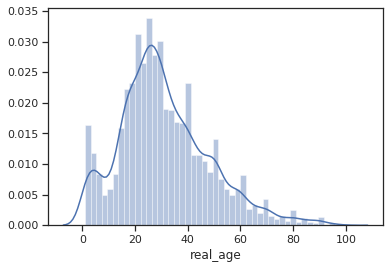

In [7]:
sns.distplot(df['real_age'])

- Most people are in the age range of 30s. Max 317 images are for age 30.
- Very few people in range above 80.
- Good range of people in 0-5 age range.

In [8]:
bins = [0, 10, 20, 30, 40,50,60,70,80,90,100]
df['agerange'] = pd.cut(df['real_age'], bins)
display(df.head(5))

,file_name,real_age,agerange
0,000000.jpg,4,"(0, 10]"
1,000001.jpg,18,"(10, 20]"
2,000002.jpg,80,"(70, 80]"
3,000003.jpg,50,"(40, 50]"
4,000004.jpg,17,"(10, 20]"


In [9]:
df_stats = df.pivot_table(index=['agerange'],values='real_age',aggfunc=['count'])
df_stats.columns= [('Count')]
df_stats

,Count
agerange,
"(0, 10]",708
"(10, 20]",1346
"(20, 30]",2214
"(30, 40]",1414
"(40, 50]",929
"(50, 60]",534
"(60, 70]",254
"(70, 80]",111
"(80, 90]",68


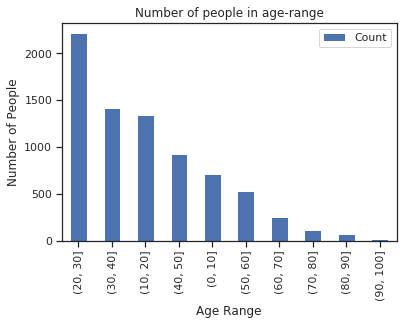

In [10]:
df_stats.sort_values(by='Count',ascending=False).plot(kind='bar',title='Number of people in age-range')
plt.xlabel('Age Range')
plt.ylabel('Number of People')
plt.show();

- Most people are in age range 20-30. 
- Few people after age 60
- This will result in good detection of people in age range below 60.
- Since there are not many images for people above age 60, the training set will not have good amount of data beyond age of 60. The age prediction for the age above 60 may be incorrect.


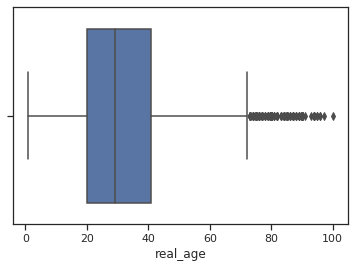

In [11]:
sns.boxplot(df['real_age'])

- The boxplot confirms that the people about age 70 are outliers - implying very few images of people above age 70.

In [12]:
print (df['file_name'].head(5))
arr = file_faces+df['file_name']
age=df['real_age']

0    000000.jpg
1    000001.jpg
2    000002.jpg
3    000003.jpg
4    000004.jpg
Name: file_name, dtype: object


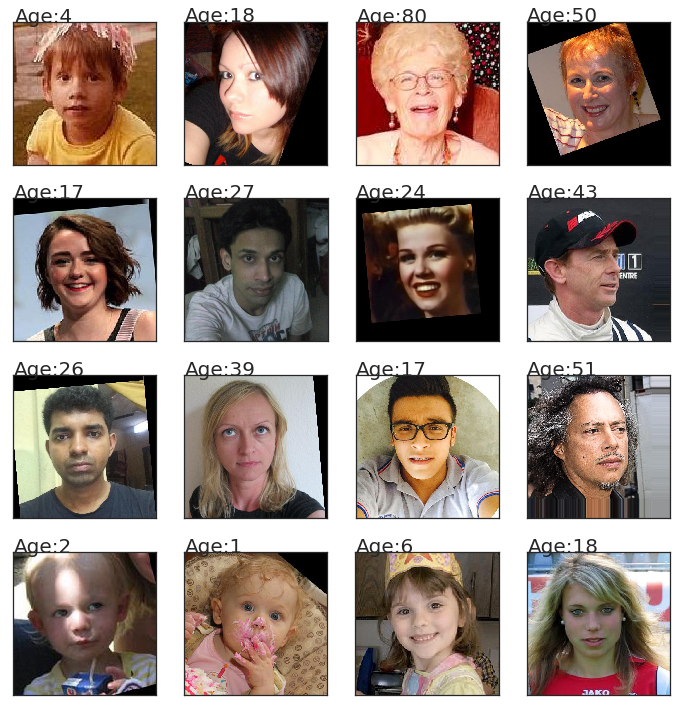

In [13]:
fig = plt.figure(figsize=(10,10))
for i in range(16):
#    print(arr[i])
    image = Image.open(arr[i])
    array = np.array(image)
    array= array/255
    
    ax=fig.add_subplot(4, 4, i+1)
    ax.annotate('Age:' + str(age[i]),fontsize=20,xy=(0.5,0.5))
    plt.imshow(array, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

## Image Analysis Conclusion:
- Images seem to be correctly related with Age
- Most people are in the age range of 30s. Max 317 images are for age 30.
- Very few people in range above 80.
- Good range of people in 0-5 age range.
- This will result in good detection of people in age range below 60.
- Since there are not many images for people above age 60, the training set will not have good amount of data beyond age of 60. The age prediction for the age above 60 may be incorrect.
- Images seem to be bright. Images are flipped right or left. Hower no vertical flipping seen.
- Few images are zoomed out. Few images seem to be darker.

# 2. Model training

Transfer the model training code and the result of printing on the screen here.


(The code in this section is run on a separate GPU platform, so it is not designed as a cell with a code, but as a code in a text cell)

```python

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    datagen = ImageDataGenerator(
        horizontal_flip=True,
        validation_split=0.25,
        rescale=1/255.)

    train_datagen_flow = datagen.flow_from_dataframe(
        target_size=(224,224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        x_col='file_name',
        y_col='real_age',
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        seed=12345)

    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255.)

    test_datagen_flow = datagen.flow_from_dataframe(
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        x_col='file_name',
        y_col='real_age',
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        seed=12345)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape=(150, 150, 3),
                    weights='imagenet',
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(12, activation='relu'))
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])


    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=3,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,shuffle=True)

    return model

```

```

# < paste the result of printing on the screen here >
# < you can delete long lines with model downloading>
Train for 356 steps, validate for 119 steps
Epoch 1/5
2021-01-30 02:44:21.738451: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2021-01-30 02:44:26.499422: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 129s - loss: 181.8556 - mae: 9.8455 - val_loss: 333.4654 - val_mae: 13.4960
Epoch 2/5
356/356 - 40s - loss: 80.0211 - mae: 6.7715 - val_loss: 148.3297 - val_mae: 9.3236
Epoch 3/5
356/356 - 40s - loss: 53.7589 - mae: 5.6133 - val_loss: 83.7431 - val_mae: 6.7788
Epoch 4/5
356/356 - 41s - loss: 41.2903 - mae: 4.8968 - val_loss: 74.4393 - val_mae: 6.3124
Epoch 5/5
356/356 - 40s - loss: 30.5706 - mae: 4.2126 - val_loss: 99.5845 - val_mae: 7.3382
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 99.5845 - mae: 7.3382
Test MAE: 7.3382
```

# 3. Trained model analysis

- I ran the training model for 5 epochs.
- Images were augmented for horizontal flipping. 
- The final test MAE was 7.3382 at epoch #5. 
- Best MAE was at epoch #4, MAE of 6.3124
- The MAE result shows that the age was deflected plus / minus 7.4 for each image. This was the mean. So some images had age deflected more than others.
- Based on the EDA results, this is expected. Reason: While there were good number of images for training set, the number of iages in thei higher group, age 60 and above were very few (1 for each age).
- If the training model had more images for higher age groups, we woudd get better resulta.

### Improvemments that could be done:
- Add augmentation for zoom-in, zoom-out, brightness of picture, slight shift right / left.

# Checklist

- [X]  Notebook was opened
- [X]  The code is error free
- [X]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [X]  The results of the exploratory data analysis have been transferred to the final notebook
- [x]  The model's MAE score is not higher than 8
- [X]  The model training code has been copied to the final notebook
- [x]  The model's printing on the screen result has been transferred to the final notebook
- [x]  The findings have been provided based on the results of the model training